In [1]:
import os

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
import pickle


In [2]:
def gaussian(x, mu = 0, sigma = 1):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

In [3]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [4]:
def boxcar(x):
    y = np.zeros(len(x))
    y = y + 1
    return y

In [5]:
def trapezium(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.linspace(0, 1, start_index)
    y[start_index:length-end_index] = 1
    y[length-end_index:] = 1 - np.linspace(0, 1, end_index)
    return y


In [6]:
def sine_boxcar(x, start = 0.3333, end = 0.3333):
    length = len(x)
    start_index = int(length*start)
    end_index = int(length*end)
    print(length, start_index, end_index)

    y = np.zeros(length)

    y[:start_index] = np.sin(np.linspace(-math.pi/2, math.pi/2, start_index))
    y[start_index:length-end_index] = 1
    y[length-end_index:] = (np.sin(np.linspace(-math.pi/2, math.pi/2, start_index)))[::-1]
    return y

In [7]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    #print('dx', dx)
    #print('endtime', end_time)
    #print('points before zero', points_before_zero)
    end_window = (end_time/dx)+points_before_zero
    #print('end winodw', end_window)
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [8]:
def comparison_calculation(funct):
    proportions_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

    #print(proportion)
    durations = []
    g_root_times = []
    g_relative_root_times = []


    for proportion in proportions_list:

        diff = []
        moments = []


        # Generate x values
        x = np.linspace(-4, 4, 100)

        # Generate y values
        y = funct(x)

        # Use the generated Gaussian values
        momentrate_opt, time_opt = y, x

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        g_root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        g_root_idx = np.floor(g_root/dx)
        g_root_time = g_root_idx*dx
        g_root_times.append(g_root_time)
        g_relative_root_times.append(g_root_time-start_time)

    g_relative_root_times = np.array(g_relative_root_times)
    return g_relative_root_times/durations

In [9]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [10]:
df = pd.read_csv(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/isc_relative_root_times_5.csv')

In [11]:
df

,Unnamed: 0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
0,20201227_2139,0.072917,0.104167,0.125000,0.145833,0.177083,0.229167,0.270833,0.322917,0.354167,0.385417,0.427083,0.489583,0.531250,0.583333,0.614583,0.677083,0.739583,0.802083,0.864583
1,20200306_1028,0.087302,0.158730,0.238095,0.285714,0.325397,0.357143,0.388889,0.412698,0.436508,0.460317,0.476190,0.492063,0.523810,0.539683,0.571429,0.603175,0.650794,0.746032,0.873016
2,20201206_1647,0.103448,0.149425,0.172414,0.172414,0.195402,0.218391,0.241379,0.264368,0.298851,0.321839,0.356322,0.390805,0.436782,0.471264,0.505747,0.563218,0.655172,0.747126,0.873563
3,20200314_1001,0.078431,0.098039,0.127451,0.176471,0.254902,0.313725,0.352941,0.411765,0.450980,0.480392,0.509804,0.539216,0.568627,0.598039,0.627451,0.676471,0.715686,0.774510,0.852941
4,20200621_1907,0.096774,0.129032,0.161290,0.193548,0.233871,0.266129,0.306452,0.338710,0.354839,0.387097,0.411290,0.435484,0.491935,0.540323,0.580645,0.637097,0.677419,0.733871,0.838710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,20201221_1708,0.078652,0.101124,0.123596,0.134831,0.168539,0.202247,0.269663,0.314607,0.359551,0.404494,0.471910,0.539326,0.584270,0.629213,0.674157,0.719101,0.764045,0.808989,0.887640
143,20201227_0637,0.089888,0.123596,0.157303,0.179775,0.202247,0.235955,0.247191,0.292135,0.314607,0.337079,0.359551,0.404494,0.426966,0.471910,0.528090,0.595506,0.662921,0.719101,0.808989
144,20201122_0054,0.132353,0.176471,0.205882,0.220588,0.235294,0.264706,0.294118,0.323529,0.323529,0.352941,0.411765,0.441176,0.470588,0.529412,0.544118,0.588235,0.647059,0.720588,0.838235
145,20201229_0710,0.117647,0.176471,0.205882,0.235294,0.294118,0.323529,0.323529,0.352941,0.382353,0.411765,0.441176,0.485294,0.529412,0.588235,0.632353,0.661765,0.720588,0.779412,0.852941


In [12]:
for dataset in ['isc', 'scardec', 'ye', 'usgs', 'sigloch']:
	df = pd.read_csv(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/{dataset}_relative_root_times_5.csv')
	df.columns = ['event', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85','90','95']

	#all_relative_root_times = [[],[],[],[],[],[],[],[],[],[],[]]
	all_relative_root_times = [[]]

	cols = ['5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85','90','95']
	for column in cols:
		all_relative_root_times.append(list(df[column].values))

	sns.set_theme(style='ticks',
				context='talk',
				rc={'figure.figsize':(10,10),
					'font.size':20})

	ax = sns.violinplot(data = all_relative_root_times,
						orient = 'h',
						color = 'silver')
	ax.set_yticks(np.arange(len(np.arange(0, 1.1, 0.05))), [f'{p*100:.0f}%' for p in np.arange(0, 1.1, 0.05)])

	ax.set_ylabel('Percentage of moment released')
	ax.set_xlabel('Proportion of duration')

	ax.invert_yaxis()

	ax.plot(np.arange(0, 1.1, 0.05),
			np.arange(0, 22, 1),
			c = 'orange',
			label = 'y = x',)

	means = []
	medians = []

	for i in all_relative_root_times[1:-1]:
		total = np.sum(i)
		#print(total)
		mean = total/len(i)
		#print(mean)
		means.append(mean)
		medians.append(np.median(i))
		#print(np.median(i))
	# Calculate the line of best fit
	m, b = np.polyfit(means, np.arange(1, 19, 1), 1)
	# Plot the line of best fit
	# ax.plot(np.mean(all_relative_root_times[1:-1], axis=1),
	#         m * np.mean(all_relative_root_times[1:-1], axis=1) + b,
	#         c='red',
	#         label = 'Mean LoBF',
	#         linestyle = '--')

	# Calculate the line of best fit
	m, b = np.polyfit(medians, np.arange(1, 19, 1), 1)
	# Plot the line of best fit
	ax.plot(np.arange(0, 1, 0.05),
			m * np.arange(0, 1, 0.05) + b,
			c='hotpink',
			label = f'{dataset} Best fit through medians',
			linestyle = '-')


	for funct, label in zip([gaussian, triangle, boxcar, trapezium, sine_boxcar], ['Gaussian', 'Triangle', 'Boxcar', 'Trapezium', 'Sine Boxcar']):
			ax.plot(comparison_calculation(funct), np.arange(1, 20, 1), label = label)

	plt.ylim(-0, 20)
	plt.xlim(0, 1)

	ax.axvspan(1, 1.5, alpha = 0.2, color = 'grey')
	plt.legend()
	sns.despine()
	#plt.show()
	plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/comparisons_to_predictions/violinplot_{dataset}_5.png', dpi = 300)
	plt.close()

0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
0.2475
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 33 33
100 

In [13]:
len(means)

18

In [14]:
len(np.arange(1, 19, 1))

18

NameError: name 'proportions_list' is not defined

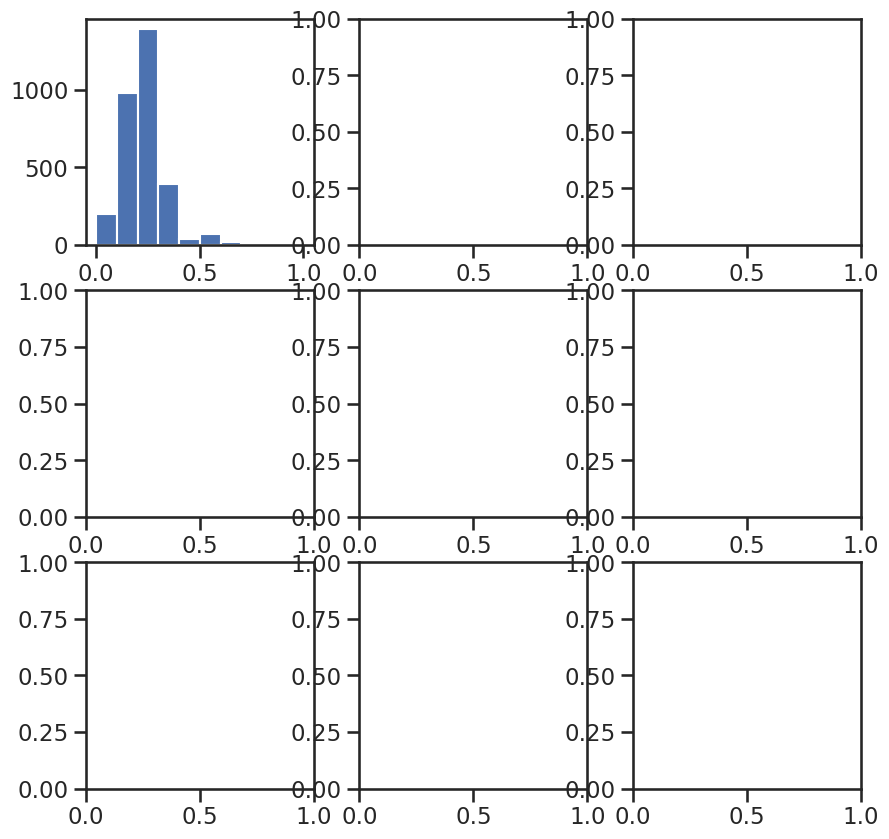

In [15]:
fig, axs = plt.subplots(3,3)
for i in range(9):
    ax = axs[i//3, i%3]
    ax.hist(all_relative_root_times[i+1], bins = np.arange(0 , 1.1, 0.1))
    ax.set_title(f'{proportions_list[i]*100:.0f}%')

    ax.set_yscale('log')

plt.tight_layout()
# plt.hist(all_relative_root_times[1:2])
# plt.yscale('log')

20101221_1719
20140401_2346
19940602_1817
20160829_0429
20160302_1249
20030715_2027
20180114_0918
20210213_1407
20150329_2348
19970421_1202
20130208_1526
20241110_1649


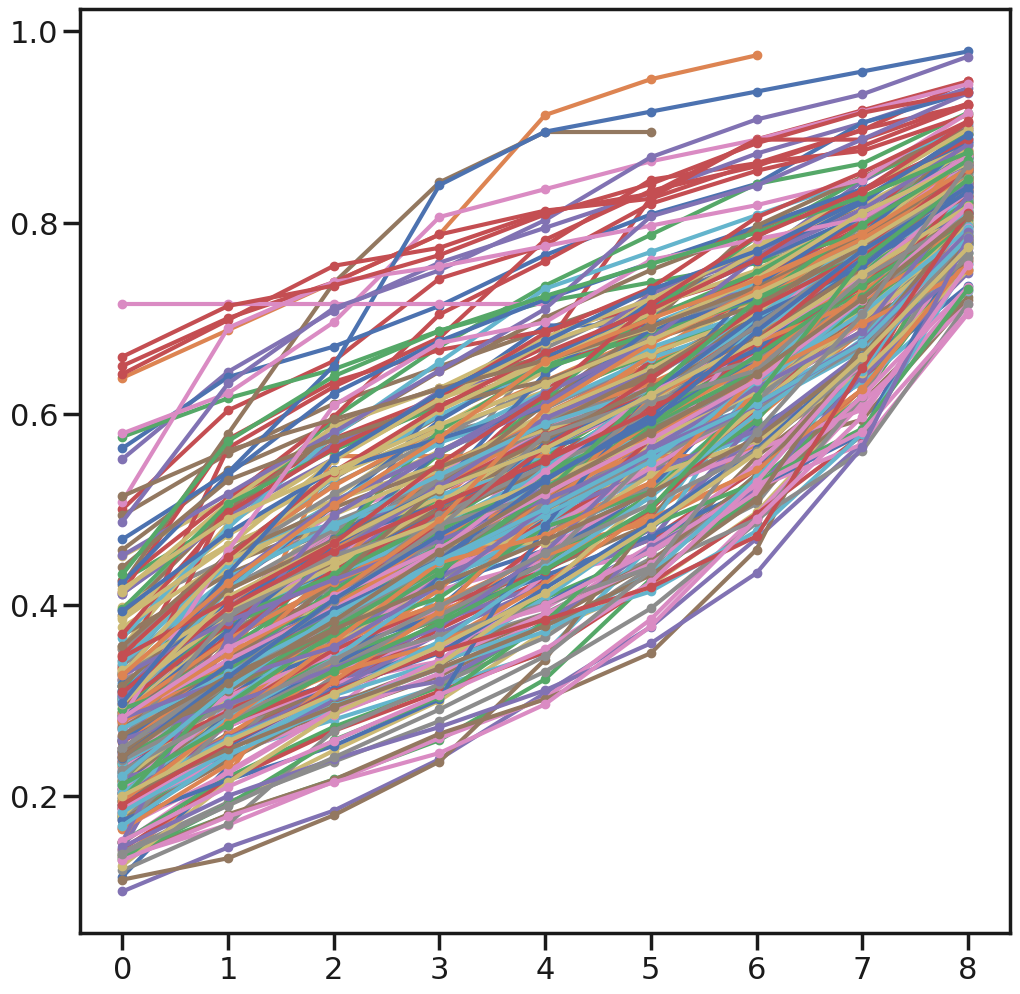

In [22]:
count = 0
for key in all_relative_root_times_for_event.keys():
    plt.plot(np.array(all_relative_root_times_for_event[key]), marker = '.')
    if all_relative_root_times_for_event[key][0] > 0.5:
        print(key)
    if all_relative_root_times_for_event[key][3] < 0.1:
        print(key)
    # count += 1
    # if count > 100:
    #     break
plt.show()